# **extract data on colab**

In [1]:
!unrar x data.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from data.rar

Extracting  data.csv                                                      99%  OK 
All OK


# **Import packages**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt    
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras
import tensorflow
from tensorflow.keras.layers import LSTM,Bidirectional
from keras.models import Model
import tensorflow as tf
from keras import Sequential
from keras.layers import Input, Dense, Embedding, Dropout, Flatten, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix


# **Read Data**

In [3]:
data = pd.read_csv("data.csv" )
data.head()

,Date,id,Number_of Vessels_Entering_the_grid,Average_ships_speed,Minimum_ships_speed,Maximum_ships_speed,Average_Wind_direction(deg),Average_GUST_wind_speed(m/s),Average_Humidity(%),Average_Temperature(C),Average_Water_temperature(C)),Average_Wind_speed(m/s)_x,Average_Minimum_wave_height(m),Average_Maximum_wave_height(m),Average_wave_height(m),Average_Wave_period(sec),Average_Wave_direction(deg),Average_Wind_speed(m/s)_y,Maximum_depth,Minimum_depth,N_of_accident
0,2018-05-01,467,6,62.051282,0.000000,110.000000,117.875000,5.691667,1015.333333,85.250000,15.466667,15.383333,0.916667,0.575000,0.408333,4.891667,181.791667,4.358333,2011.287,1676.749,0
1,2018-05-01,296,72,17.358121,0.000000,230.000000,84.583333,3.404167,1015.854167,81.958333,13.179167,15.066667,1.070833,0.625000,0.454167,5.545833,115.625000,2.650000,100.455,0.384,0
2,2018-05-01,124,1,553.333333,553.333333,553.333333,110.208333,6.550000,1012.991667,97.909091,18.000000,17.575000,1.054167,0.650000,0.475000,4.725000,112.791667,4.920833,53.813,53.752,0
3,2018-05-01,447,1,100.000000,100.000000,100.000000,113.500000,4.947917,1014.312500,94.787879,17.537500,16.912500,0.902083,0.552083,0.397917,4.385417,160.708333,3.768750,2000.933,1327.233,0
4,2018-05-01,205,3,47.784926,32.857143,64.065934,110.208333,6.550000,1012.991667,97.909091,18.000000,17.575000,1.054167,0.650000,0.475000,4.725000,112.791667,4.920833,119.249,99.390,0


In [4]:
label_main=np.array(data["N_of_accident"])
data_main=data.drop(["N_of_accident"],axis=1)
print("label shape",label_main.shape)
print("data shape",data_main.shape)

label shape (92345,)
data shape (92345, 20)


# **change labels to 0 or 1 for classification approach**

In [5]:
label_main[label_main!=0]=1

In [6]:
np.unique(label_main, return_counts=True) 

(array([0, 1]), array([89996,  2349]))

# **drop unnecessary columns**

In [11]:
data_main.drop(["Date"],axis=1,inplace=True)
data_main.drop(["id"],axis=1,inplace=True)

# **seperate data by types**

In [12]:
features_type1=["Average_ships_speed","Minimum_ships_speed","Maximum_ships_speed"]
features_type2=["Number_of Vessels_Entering_the_grid","Average_Wind_direction(deg)","Average_GUST_wind_speed(m/s)","Average_Humidity(%)","Average_Temperature(C)","Average_Wind_speed(m/s)_y"]
features_type3=["Average_Water_temperature(C))","Average_Minimum_wave_height(m)","Average_Maximum_wave_height(m)","Average_wave_height(m)","Average_Wave_period(sec)","Average_Wave_direction(deg)","Maximum_depth","Minimum_depth"]
features_type1_idx=data_main.columns.get_indexer(features_type1)  # for ConvLSTM
features_type2_idx=data_main.columns.get_indexer(features_type2)  # for LSTM
features_type3_idx=data_main.columns.get_indexer(features_type3)  #for CNN


# **undersampling**

In [13]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rand_under_samp = RandomUnderSampler(random_state=0)
data_main, label_main = rand_under_samp.fit_resample(data_main,label_main)
counter = Counter(label_main)
counter


Counter({0: 2349, 1: 2349})

# **Normalize Data**

In [14]:
scaler = MinMaxScaler()
scaler.fit(data_main)
data_normalized=scaler.transform(data_main)

# **split data to train and test sets**

In [15]:
train_data, test_data, train_label, test_label = train_test_split(data_normalized, label_main, test_size=0.2, random_state=0,shuffle=True)

In [16]:
# train_data
features_type1_train_data=train_data[:,features_type1_idx]  #convLSTM data
features_type2_train_data=train_data[:,features_type2_idx]  # LSTM data
features_type3_train_data=train_data[:,features_type3_idx]  #CNN data

# test data
features_type1_test_data=test_data[:,features_type1_idx]
features_type2_test_data=test_data[:,features_type2_idx]
features_type3_test_data=test_data[:,features_type3_idx]


# **set epoch and batch size**

In [17]:
my_epoch=100
my_batch_size=2000

# **DSTOAP**

In [18]:
from tensorflow import keras
from tensorflow.keras.models import Model


# input layers definition
cnn_input_layer = keras.layers.Input(shape=(features_type3_train_data.shape[1], 1), name='cnn_input_layer')
lstm_input_layer = keras.layers.Input(shape=(features_type2_train_data.shape[1], 1), name='lstm_input_layer')
conv_lstm_input_layer = keras.layers.Input(shape=(1,features_type1_train_data.shape[1],1), name='conv_lstm_input_layer')


# CNN part
cnn_layer_1 = keras.layers.Conv1D(filters=64,kernel_size=(3),strides=(1),padding="same",name="cnn_layer_1")(cnn_input_layer)
pool_layer_1=keras.layers.MaxPooling1D(pool_size=2)(cnn_layer_1)
cnn_layer_2 = keras.layers.Conv1D(filters=64,kernel_size=(3),strides=(1),padding="same",name="cnn_layer_2")(pool_layer_1)
pool_layer_2=keras.layers.MaxPooling1D(pool_size=2)(cnn_layer_2)
cnn_layer_3 = keras.layers.Conv1D(filters=64,kernel_size=(3),strides=(1),padding="same",name="cnn_layer_3")(pool_layer_2)
pool_layer_3=keras.layers.MaxPooling1D(pool_size=2)(cnn_layer_3)


# LSTM part
lstm_layer_1=keras.layers.LSTM(units =64,name="lstm_layer_1",return_sequences = True)(lstm_input_layer)
lstm_layer_2=keras.layers.LSTM(units =64,name="lstm_layer_2",return_sequences = True)(lstm_layer_1)
lstm_layer_3=keras.layers.LSTM(units =64,name="lstm_layer_3")(lstm_layer_2)


# ConvLSTM part
conv_lstm_layer_1=keras.layers.ConvLSTM1D(filters=64, kernel_size=(2), activation='relu',return_sequences = True )(conv_lstm_input_layer)
conv_lstm_layer_2=keras.layers.ConvLSTM1D(filters=64, kernel_size=(2), activation='relu',return_sequences = True )(conv_lstm_layer_1)
conv_lstm_layer_3=keras.layers.ConvLSTM1D(filters=64, kernel_size=(1), activation='relu' )(conv_lstm_layer_2)
# Merge features
conv_lstm_layer_3=keras.layers.Flatten(name="ConvLSTM_features")(conv_lstm_layer_3)
pool_layer_3=keras.layers.Flatten(name="CNN_features")(pool_layer_3)
lstm_layer_3=keras.layers.Flatten(name="LSTM_features")(lstm_layer_3)
Feature_Merge_Layer =keras.layers.Concatenate(axis=-1,name="Feature_Merge_Layer")([conv_lstm_layer_3,pool_layer_3,lstm_layer_3])  # axis=-1: last axis
# fully connected layers
# fully_connected_layer_1 =keras.layers.Dense(1000,activation="relu",name="fully_connected_layer_1")(Feature_Merge_Layer)
# drp_layer_1 =keras.layers.Dropout(0.4)(fully_connected_layer_1)
fully_connected_layer_2 =keras.layers.Dense(300,activation="relu",name="fully_connected_layer_2")(Feature_Merge_Layer)
drp_layer_2 =keras.layers.Dropout(0.4)(fully_connected_layer_2)
fully_connected_layer_3 =keras.layers.Dense(200,activation="relu",name="fully_connected_layer_3")(drp_layer_2)
drp_layer_3 =keras.layers.Dropout(0.3)(fully_connected_layer_3)
fully_connected_layer_4 =keras.layers.Dense(100,activation="relu",name="fully_connected_layer_4")(drp_layer_3)
# drp_layer_4 =keras.layers.Dropout(0.1)(fully_connected_layer_4)
# fully_connected_layer_5 =keras.layers.Dense(50,activation="relu",name="fully_connected_layer_5")(drp_layer_4)

prediction_output =keras.layers.Dense(1,activation="sigmoid",name="prediction_output")(fully_connected_layer_4)
dstoap_model = Model(inputs=[conv_lstm_input_layer,cnn_input_layer,lstm_input_layer], outputs=[prediction_output])
my_optimizer=keras.optimizers.Adam(learning_rate=0.001)
dstoap_model.compile(optimizer=my_optimizer,loss=keras.losses.binary_crossentropy,metrics=["accuracy"])


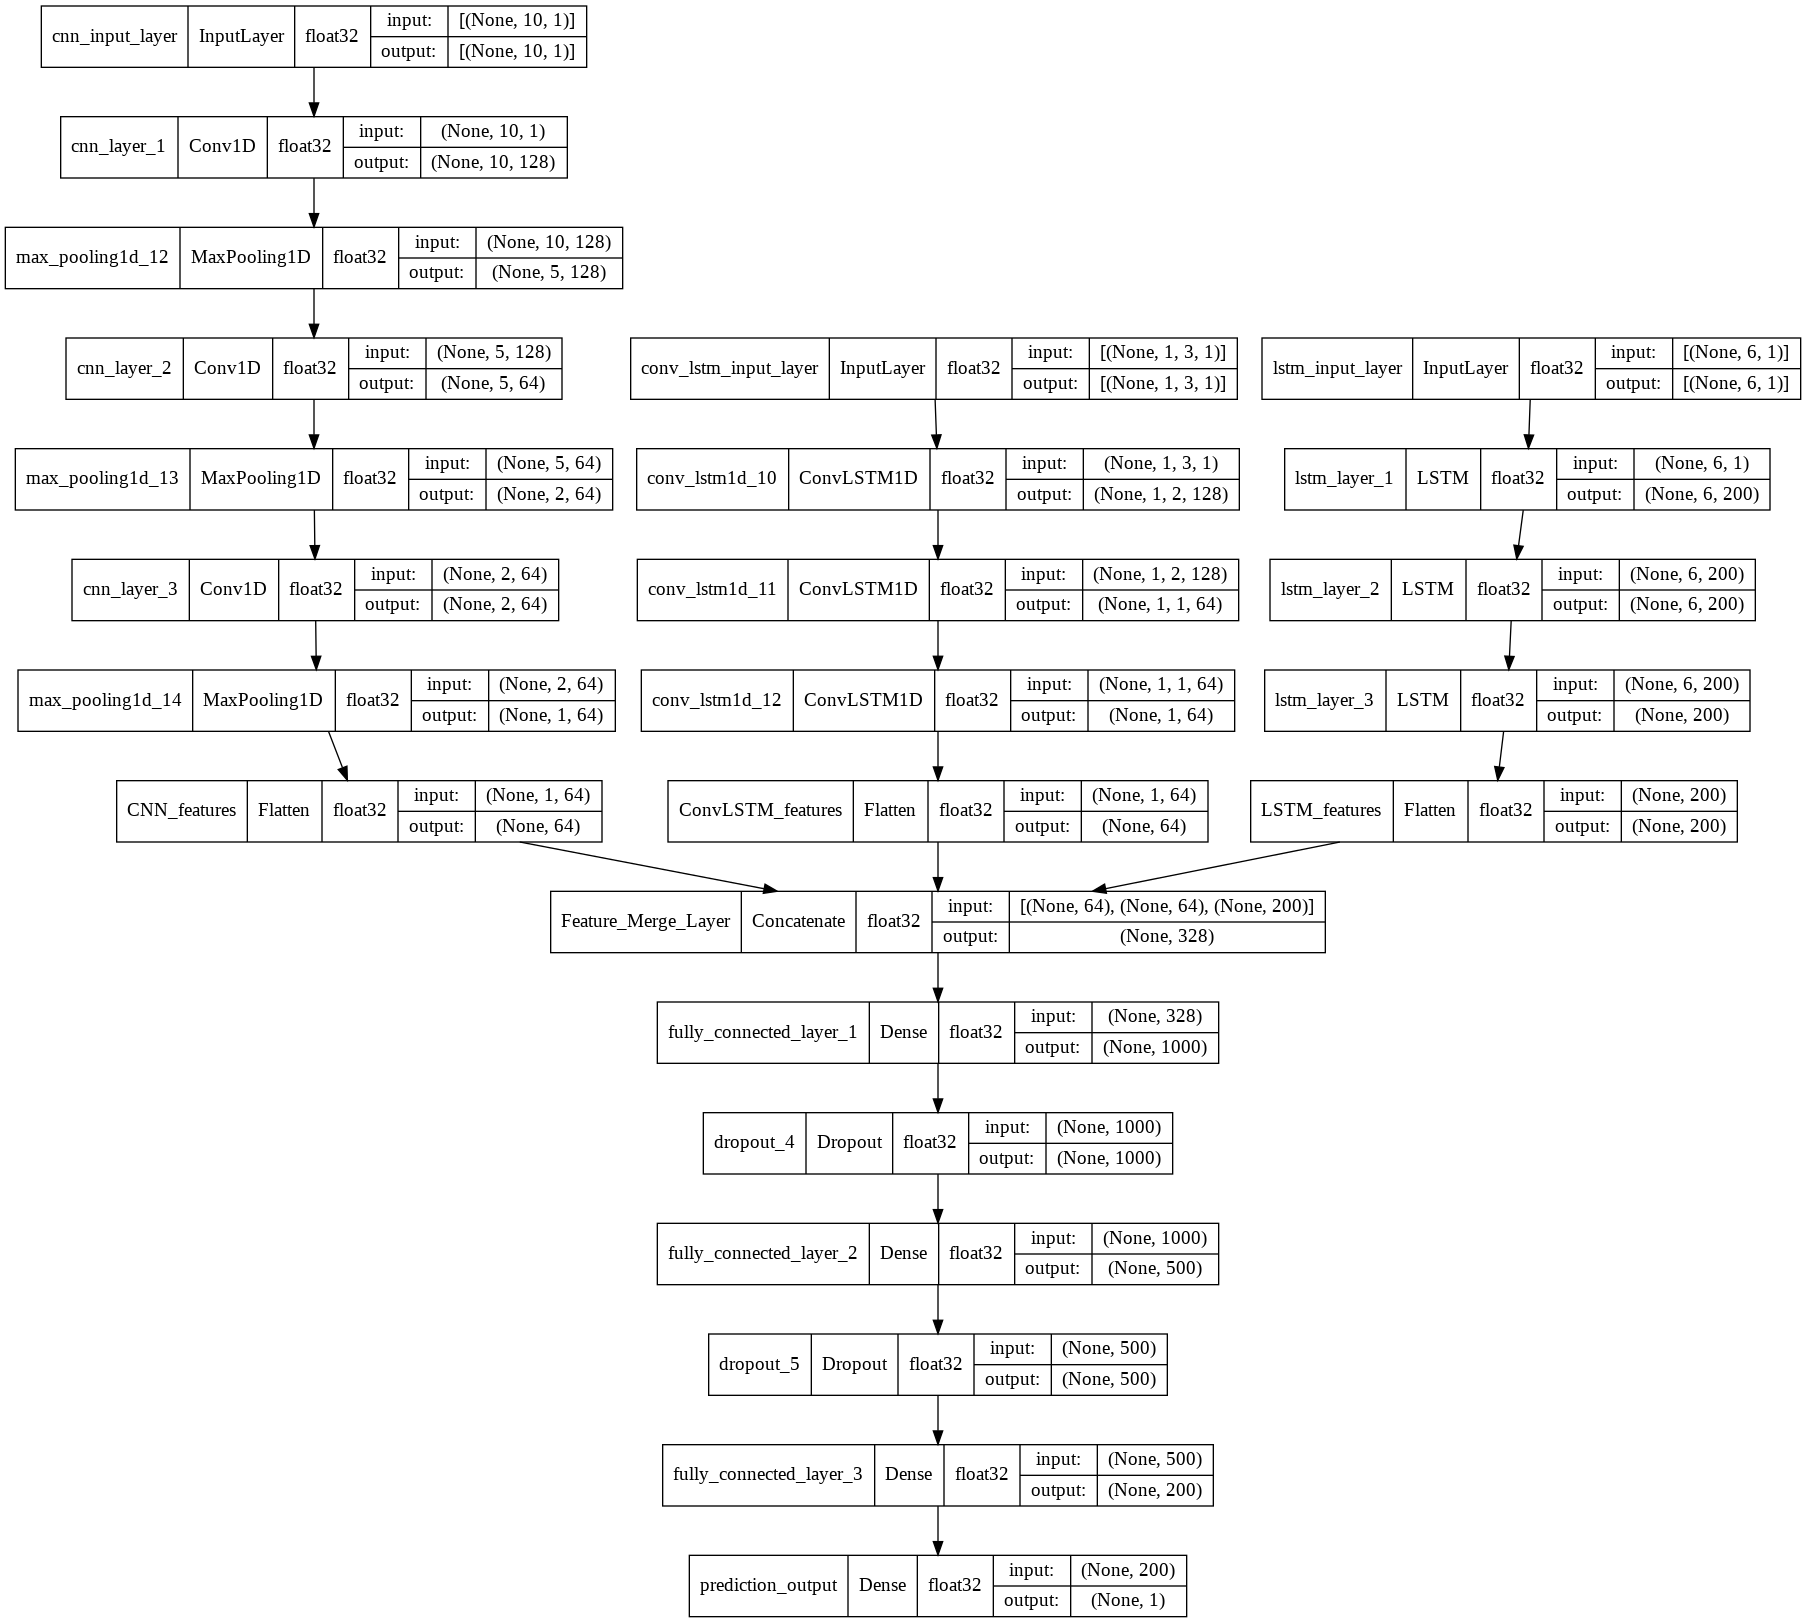

In [ ]:
keras.utils.plot_model(dstoap_model, show_shapes=True,show_layer_names=True,show_dtype=True,expand_nested=True)

# **reshape ConvLSTM data**

In [ ]:
features_type1_train_data.shape

(3758, 3)

In [19]:
# features_type1_train_data  #convLSTM data
# features_type2_train_data  # LSTM data
# features_type3_train_data  #CNN data

convLstm_data=features_type1_train_data.reshape(features_type1_train_data.shape[0],1,features_type1_train_data.shape[1],1)
convLstm_test_data=features_type1_test_data.reshape(features_type1_test_data.shape[0],1,features_type1_test_data.shape[1],1)
convLstm_data.shape

(3758, 1, 3, 1)

In [20]:
my_epoch=100
my_batch_size=3000

In [21]:
stcl_hist=dstoap_model.fit([convLstm_data,features_type3_train_data,features_type2_train_data],train_label,epochs=my_epoch,batch_size=my_batch_size)

Epoch 1/100
2/2 [==============================] - 23s 220ms/step - loss: 0.6930 - accuracy: 0.5173
Epoch 2/100
2/2 [==============================] - 1s 204ms/step - loss: 0.6901 - accuracy: 0.5740
Epoch 3/100
2/2 [==============================] - 1s 198ms/step - loss: 0.6854 - accuracy: 0.5987
Epoch 4/100
2/2 [==============================] - 1s 201ms/step - loss: 0.6764 - accuracy: 0.6200
Epoch 5/100
2/2 [==============================] - 1s 211ms/step - loss: 0.6646 - accuracy: 0.6203
Epoch 6/100
2/2 [==============================] - 1s 199ms/step - loss: 0.6499 - accuracy: 0.6293
Epoch 7/100
2/2 [==============================] - 1s 200ms/step - loss: 0.6411 - accuracy: 0.6240
Epoch 8/100
2/2 [==============================] - 1s 202ms/step - loss: 0.6419 - accuracy: 0.6248
Epoch 9/100
2/2 [==============================] - 1s 214ms/step - loss: 0.6379 - accuracy: 0.6368
Epoch 10/100
2/2 [==============================] - 1s 217ms/step - loss: 0.6265 - accuracy: 0.6410
Epoch 11

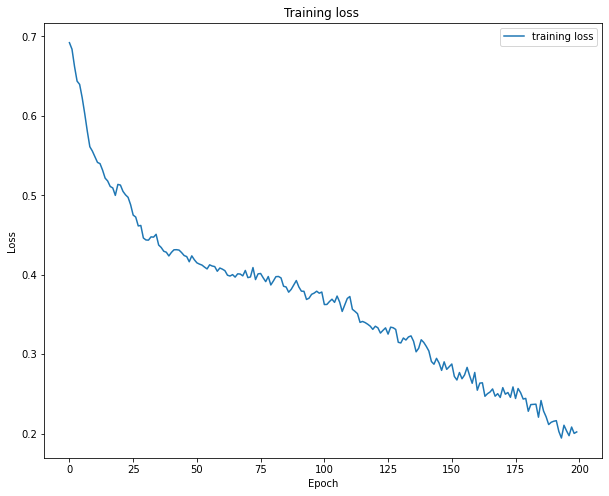

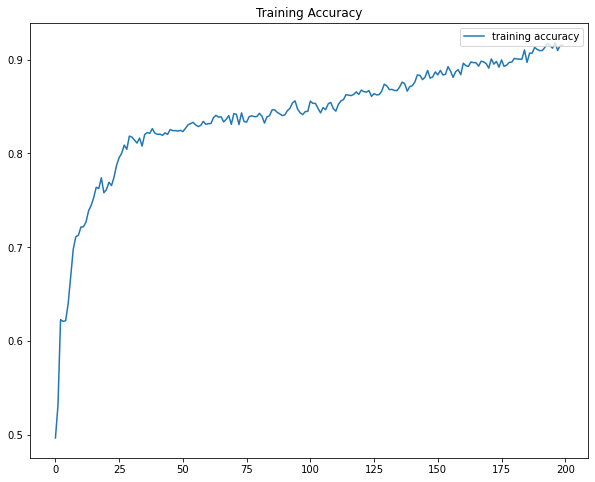

In [ ]:
acc = stcl_hist.history['accuracy']
loss = stcl_hist.history['loss']

plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), loss, label='training loss')
plt.legend(loc='upper right')
plt.title('Training loss ')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), acc, label='training accuracy' )
plt.legend(loc='upper right')
plt.title('Training Accuracy')
plt.show()

In [22]:
y_pred_stcl = dstoap_model.predict([convLstm_test_data,features_type3_test_data,features_type2_test_data])
y_pred_stcl[y_pred_stcl > 0.5]=1
y_pred_stcl[y_pred_stcl < 0.5]=0

In [23]:
def plot_results(lbl_test,y_pred,clf_name):

  label_names=["non_accident","accident"]
  Con_matrix=confusion_matrix(lbl_test, y_pred)
  fig, ax = plot_confusion_matrix(conf_mat=Con_matrix,
                                  show_absolute=True,
                                  show_normed=False,

                              )
  tick_marks = np.arange(len(label_names))
  plt.xticks(tick_marks, label_names, rotation=90)
  plt.yticks(tick_marks, label_names)
  ax.set_title('confusion_matrix of '+clf_name)
  plt.show()


  # all mertic
  res=np.zeros(4)
  classfi_report=classification_report(lbl_test, y_pred,output_dict=True)
  res[0]=accuracy_score(lbl_test, y_pred)
  res[1]= classfi_report['macro avg']['precision'] 
  res[2]= classfi_report['macro avg']['recall']    
  res[3]= classfi_report['macro avg']['f1-score']
  
  #plot
  metric_names=["accuracy","precision","recall","f1-score"]
  fig2=plt.figure(2,figsize=(10,8)) #  
  plt.bar(metric_names, res,color = ['blue','red', 'green','black'])
  plt.xticks(metric_names, rotation=90)
  plt.ylabel('percent%' , fontweight='bold')
  plt.title('results of '+clf_name, fontweight='bold')
  plt.xlabel("metrics name", fontweight='bold')
  for i, v in enumerate(res):
      v=round(v,3)
      plt.text(i-0.2 , v+0.01 , str(v), color='blue', fontweight='bold')
  plt.show()


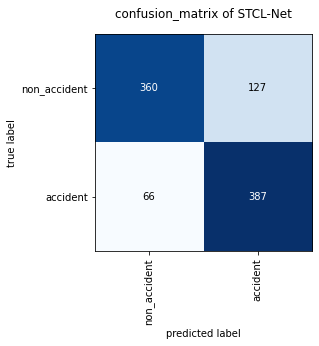

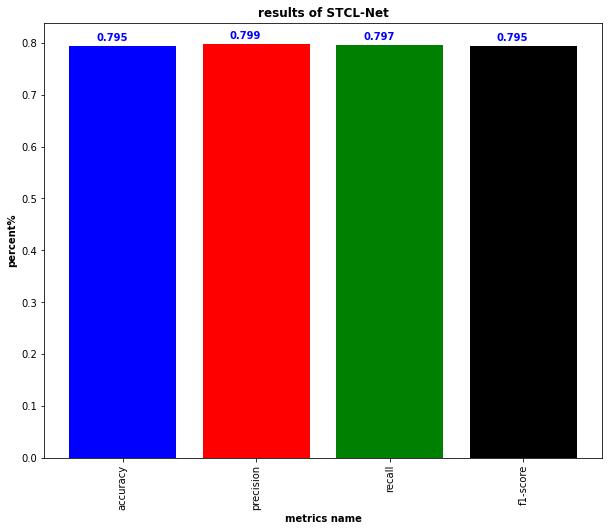

In [24]:
plot_results(test_label,y_pred_stcl ,"STCL-Net")

# **save output**

In [ ]:
prediction_result=pd.DataFrame(columns=["real_value","predicted"])
prediction_result["predicted"]=y_pred_stcl[:,0]
prediction_result["real_value"]=test_label
prediction_result.to_csv("prediction_result.csv",index=None)